# 직접 만들어보는 OCR
## Objective

1. Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다.
- 텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다.
2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다.
- 학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.
3. keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다.
- 샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.

In [41]:
import tensorflow as tf
import numpy as np
import cv2
import keras_ocr

import os
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import re
import six
import math
import lmdb

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

%matplotlib inline

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.6.0
1.21.4
4.5.3
0.8.8


In [2]:
BATCH_SIZE = 128

HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

데이터셋을 불러와 라벨을 확인하고, 전처리를 진행합니다    

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


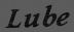

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


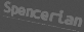

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


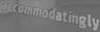

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


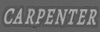

In [3]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

각기 다른 이미지 크기를 훈련을 위해 균일화하였습니다  
텍스트 이미지 리사이징이 정상적으로 수행되었습니다  

In [4]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

여기 중간에 self.img_size 앞에 왜 *이 붙는건지 모르겠음   
https://hcnoh.github.io/2019-01-27-python-arguments-asterisk   
가변적인 변수 갯수였군요  
생각해보니 * *kwarg로 함수인자 전달이 많았던 것이 기억났음  
  
각 Chara

In [5]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [6]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [7]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [8]:
def ctc_lambda_func(args):
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [9]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    # 여기부터 conv layers
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)         
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    
    # 여기부터 recurrent layers
    # 시작이 feature sequence
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    # Transcription laye
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

CRNN 모델구조를 구현합니다  
https://arxiv.org/pdf/1507.05717.pdf Fig1. 을 참고하도록 합니다

In [10]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 32, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 32, 64)  1792        input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 16, 128)  73856       max_pooling2d[0][0]              
______________________________________________________________________________________________

모델 구조를 보고나서, 파악을 할 수 있었습니ㄷr  
CTC 레이어에서는 여기서 정의해준 ctc_lambda_func 의 lambda 연산을 수행하는 레이어였습니ㄷr  
https://runebook.dev/ko/docs/tensorflow/keras/layers/lambda  
이전 layer의 연산 결과들이 사용자 정의함수를 거치는 과정이었군요 우와..  
ctc_lambda_func 에서는 여러 사용자 편의함수를 모아둔 모듈로 알고있는 keras의 backend모듈에서 정의된 ctc_batch_cost 를 불러와 사용합니다  

In [12]:

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [13]:
EPOCH = 50

In [14]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=EPOCH,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/50
565/565 [==============================] - 128s 155ms/step - loss: 25.6006 - val_loss: 23.9749

Epoch 00001: val_loss improved from inf to 23.97491, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/50
565/565 [==============================] - 83s 147ms/step - loss: 15.3107 - val_loss: 9.6588

Epoch 00002: val_loss improved from 23.97491 to 9.65882, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/50
565/565 [==============================] - 83s 147ms/step - loss: 7.1704 - val_loss: 6.5445

Epoch 00003: val_loss improved from 9.65882 to 6.54454, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/50
565/565 [==============================] - 83s 147ms/step - loss: 5.0865 - val_loss: 5.4657

Epoch 00004: val_loss improved from 6.54454 to 5.46568, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/50
565/565 [==============================] - 83s 147ms/step - loss: 4.0098 - val_loss: 4.6208

Epoch 00005: val_loss impr

4회동안 validation loss의 개선이 없어 훈련이 멈추었습니다

In [37]:
_loss = history.history['loss']
_val_loss = history.history['val_loss']

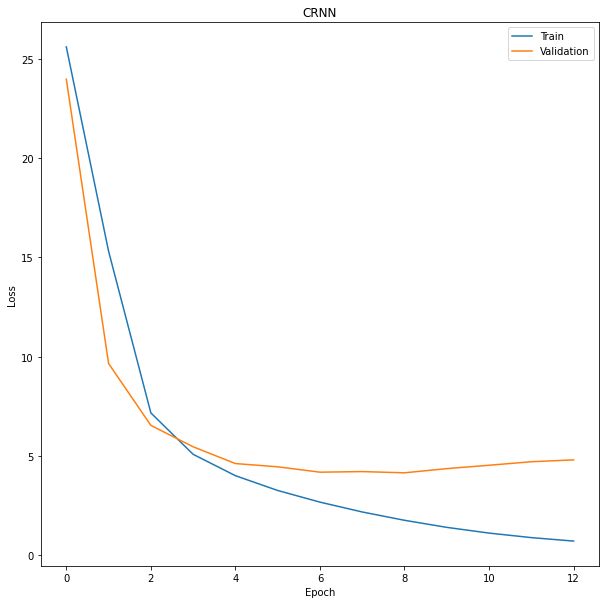

In [43]:
plt.figure(figsize=(10,10))
plt.plot(_loss)
plt.plot(_val_loss)
plt.title('CRNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')


훈련 모델의 train loss는 완만하게 수렴합니다  
validation loss 또한 진동없이 완만하게 수렴 후 약한 상승 추세를 보였습니다
  
prediction은 기존에 저장된 가중치를 사용하도록 합니다

In [15]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)



In [16]:
# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

#### 중요! 인퍼런스 모델을 따로 만들어야합니다!

Result: 	 SLINKING9999999999999999


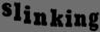

Result: 	 ALEPPO99999999999999999


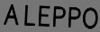

Result: 	 FWANDA999999999999999999


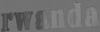

Result: 	 NATHANS99999999999999999


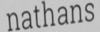

Result: 	 HALLE999999999999999999


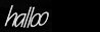

Result: 	 HURLS9999999999999999999


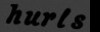

Result: 	 DOWNSIZE9999999999999999


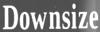

Result: 	 ROBOTIC99999999999999999


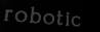

Result: 	 SLOPPY99999999999999999


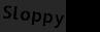

Result: 	 SHERMITE9999999999999999


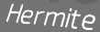

In [65]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

정성적으로 확인한 결과는 상당히 좋습니다  
뒤에 붙어나오는 9에 대해 정리하기 위해서는, 더욱 모델구조를 자세히 살펴보아야 할 것 같습니다

# END - TO - END OCR    
keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만들어보도록 하겠습니다  

In [18]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수를 keras-ocr의 Detector를 이용해서 만들어봅니다  


In [19]:
from PIL import ImageDraw

In [66]:
def detect_text(img_path):
    # TODO
    # 배치 크기를 위해서 dimension을 확장해주고 keras-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    # 배치의 첫 번째 결과만 가져옵니다.
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)    
    
    # 코드블럭3의 이미지 읽는 부분을 재현합니다
    img = Image.open(img_path)
    
    width, height = img.size
        
    target_width = min(int(width*320/height), 1000)
    target_img_size = (target_width,320)        
    img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        # print('display img shape:{}'.format(img.shape))
        # print('label:{}'.format(label))
        # display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))
        
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경하기
    img = img[tf.newaxis,...]
    
    # 배치의 첫 번째 결과만 가져오기
    detect_result = detector.detect(img)
    ocr_result = detect_result[0]
    
    # 시각화를 위해서 x와 y좌표를 변경

    img = np.squeeze(img, axis=0)
    img = Image.fromarray(img.astype(np.uint8))
    img_draw = ImageDraw.Draw(img)
    
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img.crop(word_box))
        
    return img, cropped_imgs

 inference한 후에는 이를 시각화하도록 합니다

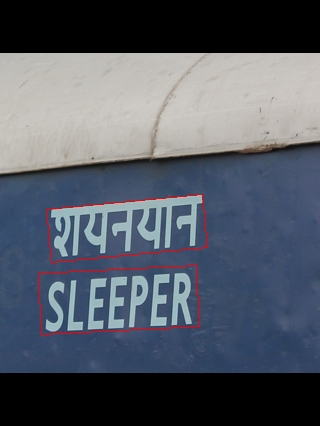

In [67]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil.rotate(90).transpose(Image.FLIP_TOP_BOTTOM))

Recognition model로 인식하는 함수를 직접 작성하고 그 결과를 출력해봅니다

In [98]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!
    pil_img = pil_img.resize(input_img_size)
    img = np.array(pil_img)
    img = np.transpose(img, (1, 0, 2))
    img = img[np.newaxis, :, :, :]
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    
    _img_size = (input_img_size[0]*5, input_img_size[1]*5)
    
    display(Image.fromarray(np.array(pil_img).transpose(1,0,2).astype(np.uint8)).resize(_img_size))

Result: 	 SERS99999999999999999999


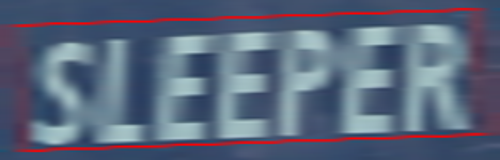

Result: 	 IEIS9999999999999999999


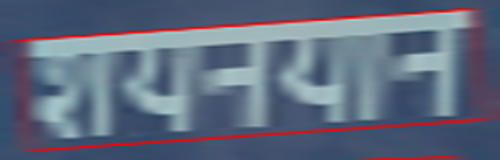

In [99]:
for _img in cropped_img:
    recognize_img(_img)

예상보다 인식 결과가 좋지 않습니다  
이미지 전처리 과정 혹은 모델 학습에서 문제가 있었는지 확인해봐야 할 것입니다

# 회고  
시간을 충분히 쓸 수 없어 아쉬운 노드였습니다  
몰입해서 본다면 얻어갈 것이 많은 코드 흐름이라고 생각하지만, 익히기가 쉽지 않아보입니다  
특히, numpy 사용법에 익숙해야 할 필요성을 많이 느꼈던 것 같습니다  
  
## Future work   
#### 후처리  
인식결과 이후 Pad부분에 쓰레기값이 들어갑니다  
해당 부분 어떻게 깔끔하게 출력할 수 있을까 확인해보아야 할 필요성이 보입니다  
  
#### 모델 성능 실험 및 비교  
전체 테스트 데이터셋을 각 모델로 평가하여, 구현한 CRNN 모델의 성능이 keras-ocr과 비교하여 어떠한지 recognition accuracy를 확인해보도록 합니다  
  
### 참고페이지
  
https://arxiv.org/pdf/1507.05717.pdf  
https://github.com/soy53/AIFFEL/blob/main/Going%20Deeper/%5BGD-12%5DOCR.ipynb  
https://tw0226.tistory.com/90  

